### A Crash Course on Neural Networks with Keras Part 5 - Deep-Q Reinforcement Learning

Finally, lets shift gears and talk about reinforcement learning. This is of course by now a huge field and we will be deliberately brief and only scratch the surface. For more depth, rigour and context, I strongly suggest this excellent [textbook](http://incompleteideas.net/book/bookdraft2018mar11.pdf).

So, what is Reinforcement learning?

In general, we imagine the setting of an Agent interacting with some Environment in discrete time steps:

<img src="images/EnvironmentAgent.png",width=350,height=350>

Very roughly, at each time step the agent is in some "state" $S_t$ - which could be a combination of its knowledge of the environment, its historical actions, and some internal variables, and it must then choose a valid action $A_t$ (or way of interacting with the environment). In response to this action, the environment changes and provides the agent with a scalar reward $R_{t+1}$ and a boolean signal which indicates whether the game is over (i.e. whether the agent fails/dies/loses). The agent then updates its state based on new information from the environment, and the loop continues. The goal of the agent is to learn how to act in such a way that maximizes the *expected discounted cumulative reward* it obtains (to be defined properly below). Note, that typically the way that the agent chooses its action, the way that the environment is effected by the action, and the reward that is generated can all be stochastic, and that in the context of finite state and action spaces this process can be formalized within the framework of finite Markov decision processes (FMDP) :

$$p(s',r|s,a) \equiv \mathrm{pr}(S_t = s',R_t = r|S_{t-1} = s, A_{t-1} = a)$$

There are by now many approaches to solving this problem, and many different algorithms. However, we will focus on an algorthim called "Deep-Q learning". Famously, this algorithm enabled agents to obtain human level performace on a variety of [Atari games](https://www.nature.com/articles/nature14236). 

#### 1a) A brief introduction to Deep-Q learning

We present a vanilla version of the algorithm used in this [Atari paper](https://www.nature.com/articles/nature14236). This explanation is going to be brief, and so I strongly suggest looking at the original paper, as well as this excellent series of [blog posts](https://medium.com/emergent-future/simple-reinforcement-learning-with-tensorflow-part-0-q-learning-with-tables-and-neural-networks-d195264329d0), and Chapter 3 of this [book](http://incompleteideas.net/book/bookdraft2018mar11.pdf).

Ok, lets get started. To understand how this works, we have to introduce a few definitions:

Firstly, we define an Agent's *policy* $\pi$ as a mapping from states to probabilities of specific actions - i.e. $\pi(a|s)$ is the probability that $A_t = a$ if $S_t = s$.

Next, for FMDP's we define the *value* of a state $s$, under policy $\pi$ as:

$$v_{\pi}(s) = \mathbb{E}_{\pi}[G_t|S_t = s]  = \mathbb{E}_{\pi} \Big[\sum_{k = 0}^{\infty}\gamma^k R_{t+k+1}\Big| S_t = s \Big] \qquad \forall S_t \in \mathcal{S} $$

where $G_t$ is the discounted return (discounted cumulative reward) with discount factor $0 \leq \gamma \leq 1$ and $v$ is the *state-value function*.

Similarly, we can define the *action-value function*  (the so called "q" function) for policy $\pi$ via:

$$q_{\pi}(s,a) = \mathbb{E}_{\pi}[G_t|S_t = s, A_t = a]  = \mathbb{E}_{\pi} \Big[\sum_{k = 0}^{\infty}\gamma^k R_{t+k+1}\Big| S_t = s, A_t = a \Big]$$

Importantly, both state and action value functions satisfy a relation (actually system of equations) known as Bellman's equation, which for action-value functions looks as follows:

$$
\begin{align}
q_{\pi}(s,a) & =  \mathbb{E}_{\pi}[G_t|S_t = s, A_t = a] \\
& = \mathbb{E}_{\pi}[R_{t+1} + \gamma G_{t+1}|S_t = s, A_t = a]\\
& = \sum_{s'}\sum_{r}p(s',r|s,a)\big[r + \gamma\mathbb{E}_{\pi}[G_{t+1}|S_{t+1} = s']\big] \\
& = \sum_{s'}\sum_{r}p(s',r|s,a)\big[r + \gamma v_{\pi}(s')\big]
\end{align}
$$

In addition, value functions allow us to place an order over policies ($\pi > \pi' \iff v_{\pi}(s) > v_{\pi'}(s)\quad \forall s \in \mathcal{S} $) such that we can define an optimal policy $\pi^*$, with respect to which the action-value function will be the unique solution of the following system of equations:

$$q_*(s,a) = \mathbb{E}\big[R_{t+1} + \gamma\max_{a'}q_{*}(S_{t+1},a')\big|S_t = s, A_t = a \big]\tag{1}$$

Now, the idea of iterative Q-learning is to start from an arbitary $q$ function, and then use eqn. (1) as an update function for an agent which uses the $q$ function to make decisions as to how to interact with the environment. The hope (can be proven under certain constraints) is that the $q$ function will eventually converge to $q_*$, which is a stationary point of eqn. (1).

More specifically, for *deep*-Q learning we parameterize $q$ with a neural network, and use eqn. (1) to construct the cost function on which we train the network. In particular we let the agent interact with the environment, using some $\epsilon$-greedy policy, in the process generating tuples of experience of the following form:

$$[S_t,A_t,R_{t+1},S_{t+1}]$$

From these tuples we can construct a loss on which to train the Q-network, by using the cost function:

$$\begin{align} 
C &= y_{\mathrm{pred}} - y_{\mathrm{true}}\\
&= q(S_t,A_t) - \big[R_{t+1} + \gamma\max_{a'}q(S_{t+1},a') \big]
\end{align}$$

which, by staring at eqn. (1), we can see will be 0 only for the optimal policy.

#### 1b) Some practical considerations

The idea of Q-learning has been around for a long time, however it is only [relatively recently](https://www.nature.com/articles/nature14236) that people started having success with deep-Q learning, as many aspects of the problem make the training process extremely unstable. In order to deal with this, the landmark deep-Q learning paper introduced the following tricks:

  - _Memory buffer_: Rather than training online after each interaction with the environment, collect experience-tuples in a memory buffer from which you can randomly sample to create training batches
  - _Seperate active and target network_: Because the q-function is used to create both the "truth-label" and the prediction of the cost function, training can be extremely unstable. To fix this one can create a target network, which is an exact copy of the q-network from which the agent is making decisions, but which is updated less frequently.
  
In addition to these tricks, there have since been subsequent additional ideas, which have helped a lot:

  - [Prioritized Experience Replay](https://arxiv.org/abs/1511.05952): Instead of sampling batches randomly from the memory buffer, sample according to a probability distribution which gives more weight to experience tuples from which the agent stands to learn more.
  - [Double Q Learning](https://arxiv.org/abs/1509.06461): When using a seperate target and active q-network, the loss function can systematically over-estimate the  value of certain actions. Double Q learning modifies the loss function to address this problem.
  - [Dualing Q Networks](https://arxiv.org/abs/1511.06581): See the paper :)

It's also worth mentioning different methods and extensions of Q-learning, such as [Asynchronous Actor Critic](https://arxiv.org/abs/1602.01783), which has proven extremely powerful.


Practically, the Q-function is parameterized via a NN which takes as input the current state $S_t$, and has as many outputs as there are legal actions, with each output corresponding to the state-action value for that action given the input state.

Once again, as when discussing GAN's, the neural network architecture via which the q function is parameterized is of course up to you - for tasks in which the state $S_t$ is an image (like in the Atari environment) it would make sense to use a CNN, or perhaps an LSTM if one wants to see historical sequences of frames.

#### 2a) Lets build and train a Deep-Q network

To give an example, we will use the [openAI gym](https://gym.openai.com/) [cart-pole environment](https://gym.openai.com/envs/CartPole-v0/).

OpenAI gym provides multiple environments which can interface with any agent you build. You just need to supply a valid action, and the environment will respond with a new environment state and a reward. There are [lots of cool environments](https://gym.openai.com/envs/#classic_control) - including locomotion and Atari :)

The cart pole task is to balance a pole on a cart:

<img src="images/cart_pole.gif",width=350,height=350>

In particular, at anytime the state of the environment that the agent has access to is a four dimensional vector:

     - [position of cart, velocity of cart, angle of pole from vertical, angular velocity of pole]

and the agent only ever has two valid actions:

     - [move_cart_left, move_cart_right]
     
The game is over when the pole hits the ground, and the agent recieves a reward of 1 for every time step in which the game is not over.

We will build a completely vanilla implementation, with a simple FFNN, in essence a simplified version of the methods used in the original [Atari paper](https://www.nature.com/articles/nature14236).

In [2]:
# ---------- Imports ---------------

import random
import gym
import numpy as np
from collections import deque

import keras
from keras.layers import Dense, Dropout, Activation, LSTM, Input
from keras.models import Model, Sequential
from keras.regularizers import l2
from keras.optimizers import Adam
from keras import backend as K
import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import clear_output

As discussed in the Atari paper, training is more stable if the losses are clipped, which can be achieved by a custom loss function, the [Huber Loss](https://en.wikipedia.org/wiki/Huber_loss). This can be defined in Keras as follows:

In [3]:
def huber_loss(y_true, y_pred, clip_delta=1.0):
    error = y_true - y_pred
    cond  = K.abs(error) < clip_delta

    squared_loss = 0.5 * K.square(error)
    linear_loss  = clip_delta * (K.abs(error) - 0.5 * clip_delta)

    return tf.where(cond, squared_loss, linear_loss)

def huber_loss_mean(y_true, y_pred, clip_delta=1.0):
    return K.mean(huber_loss(y_true, y_pred, clip_delta))

Once again we will use our simple function for building FFNN's

In [4]:
def build_FFNN(num_features, num_categories,ff_layers, learning_rate):

    nnet = Sequential()
    
    for layer in range(len(ff_layers)):
        
        if layer == 0:
            nnet.add(Dense(ff_layers[0][0], activation='relu', input_shape=(num_features,)))
        else:
            nnet.add(Dense(ff_layers[layer][0], activation='relu'))
                
        if ff_layers[layer][1] > 0:
            nnet.add(Dropout(ff_layers[layer][1]))

    nnet.add(Dense(num_categories,activation="linear"))
    
    ad_opt = Adam(lr=learning_rate)
    nnet.compile(optimizer=ad_opt, loss="mean_squared_error")
    
    return nnet

We need helper functions for action selection and batch construction:

In [5]:
def epsilon_greedy_action(Q_nn,observation,epsilon):
    
    if np.random.rand() < epsilon:
        # With probability epsilon act randomly
        action = random.randrange(2)
    else:
        # With probability 1- epsilon act in a greedy way with respect to the active Q function
        action = np.argmax(Q_nn.predict(np.expand_dims(observation,axis=0))[0])
        
    return action
       
def construct_training_batch(memory_buffer, batch_size, target_network, active_network, gamma):
    
    # Sample a random selection of experience-tuples/memories
    mini_batch = random.sample(memory_buffer, batch_size)
    
    x_batch, y_batch = [], []
    for state, action, reward, new_state, done in mini_batch:
        # For each experience-tuple in the sampled batch of memories:
        
        # Get the current action values. 
        target = active_network.predict(np.expand_dims(state,axis=0))[0]
        
        if done:
            # If in the terminal state, the expected future reward is just the current reward.
            # We replace the action value for the action we took with this value for y_true
            target[action] = reward
        else:
            # if not in the terminal state, then we bootstrap y_true using Bellmans equation for the optimal q function
            target[action] = reward + gamma*np.max(target_network.predict(np.expand_dims(new_state,axis=0))[0])
        
        # Add this state and target function to the training batch
        x_batch.append(state)
        y_batch.append(target)
        
    return np.array(x_batch), np.array(y_batch)

We can then set up the environment and define all relevant settings:

In [9]:
# ------------- Env Specification ----------

env = gym.make('CartPole-v1')

# ---------- FFNN specification -------------------

ff_layers = [[20,0],[20,0]]               # We use a very small FFNN
learning_rate = 0.001
num_outputs = 2                           # The number of outputs is the number of valid actions
num_features = 4                          # The number of features is the given by the state description

# ---------- Training specifications -------------

min_buffer_size = 100                     # We only start training after collecting 100 memories
max_buffer_size = 1000                    # The buffer is a queue with maximum length 1000
batch_size = 32       
max_episodes = 200
max_episode_length = 1000


# -------- Other agent specifications ----------

gamma = 0.99                                   # Discounting factor
epsilon_initial = 0.99                         # intial exploration probability
epsilon_decay = 0.995                          # epsilon decay factor
epsilon_min = 0.01                             # minimum exploration probability

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


And then we can train the agent:

In [10]:
# ------------ Algorithm -----------------------------------

# 1) Initialize the memory buffer
memory_buffer = deque(maxlen=3000)

# Initialize lists to store improvement metrics
episode_lengths = []

# 2) Initialize the Q network and the target Q network

Q_nn = build_FFNN(num_features, num_outputs,ff_layers,learning_rate)
Q_nn_target = build_FFNN(num_features, num_outputs,ff_layers,learning_rate)

Q_nn_weights = Q_nn.get_weights()
Q_nn_target.set_weights(Q_nn_weights)

# 3) Initialize relevant variables and counters
epsilon = epsilon_initial

stop_training = False
episode = 1
while not stop_training:
    
    # Reset the environment and relevant flags and counters
    observation = env.reset()      
    stop_episode = False
    episode_length = 1

    while not stop_episode and not stop_training:
            
        # Choose an action in an epsilon greedy manner
        action = epsilon_greedy_action(Q_nn,observation,epsilon)  
        
        # Act with this action
        new_observation, reward, terminal_state, info = env.step(action)
        
        # Construct the experience-tuple and add it to the memory buffer
        memory = [observation, action, reward, new_observation, terminal_state]
        memory_buffer.append(memory)
        
        observation = new_observation
        
        # If we have enough memories we can train the neural network
        if len(memory_buffer) > min_buffer_size:
            
            # Fetch the training batch and the targets
            training_inputs, training_targets = construct_training_batch(memory_buffer, batch_size, Q_nn_target,
                                                                        Q_nn, gamma)
            
            # Fit the neural network on this batch
            Q_nn.fit(x=training_inputs, y = training_targets, batch_size=batch_size,verbose=0)
                    
        # lets anneal the exploration probability
        if epsilon > epsilon_min:
                epsilon = epsilon*epsilon_decay
            
        # check if the episode should end:                                                      
        if terminal_state or episode_length > max_episode_length:
            stop_episode = True
            episode +=1
            episode_lengths.append(episode_length)
            
            clear_output()
            print("Episode:", episode, " Final Episode Length: ", episode_length)
            
            # Update the target neural network
            Q_nn_target.set_weights(Q_nn.get_weights())
            
        # check if training should end
        if stop_training or episode > max_episodes:
            stop_training = True
            print("Training Stopped")
            episode_lengths.append(episode_length)
                                 
        episode_length += 1

Episode: 201  Final Episode Length:  115
Training Stopped


Lets have a look at the results:

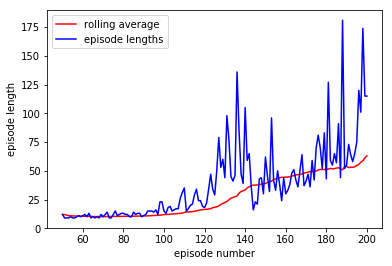

In [32]:
avg_len = [np.average(episode_lengths[j-50:j]) for j in range(50,len(episode_lengths))]
_ = plt.plot([x for x in range(50,201)],avg_len,'r', label='rolling average')
_ = plt.plot([x for x in range(50,201)],episode_lengths[50:],'b', label='episode lengths')
_ = plt.xlabel("episode number")
_ = plt.ylabel("episode length")
_ = plt.legend()

Seems like its on its way - go play :)